# Gradient verification for the 2D - non reactive transport (diffusion + advection), permeablity inversion from head - density flow

The goal here is to verify the correctness of the adjoint state method in HYTEC by comparing the results with the demonstrator's which are considered as correct.

In [1]:
import copy
import logging
import os
from pathlib import Path
from typing import Iterable, Optional

import gstools as gs
import matplotlib.pyplot as plt
import nested_grid_plotter as ngp
import numpy as np
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
import scipy as sp

# from nested_grid_plotter import make_x_axes_symmetric_zero_centered
from IPython.display import HTML
from matplotlib.animation import HTMLWriter
from matplotlib.colors import LogNorm
from pyrtid.utils import (
    NDArrayFloat,
    gen_random_ensemble,
    get_normalized_mean_from_lognormal_params,
    get_normalized_std_from_lognormal_params,
    indices_to_node_number,
)

gs.config.USE_RUST = True  # Use the rust implementation of gstools

In [2]:
from typing import List

from matplotlib.axes import Axes


def make_x_axes_symmetric_zero_centered(axes: List[Axes]) -> None:
    """
    Make all given x axes symmetric in zero.

    Always put 0 in the middle of the graph for all x axes.

    Parameters
    ----------
    axes : List[Axes]
        List of axes to adjust.

    Returns
    -------
    None.

    """
    max_lims = np.max(np.abs(np.array([ax.get_xlim() for ax in axes])), axis=1)
    for i, ax in enumerate(axes):
        ax.set_xlim([-max_lims[i], max_lims[i]])

- Set-up logging level

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test


- Check package/software versions

In [4]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.0
INFO:root:matplotlib                  = 3.6.2
INFO:root:nested_grid_plotter         = 0.1.2
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Create a directory to store the exported figures

In [5]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [6]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Forward problem

- Define a very simple pure transient density flow + transport (advection & diffusion) case in 2D.

In [7]:
max_workers = 40

In [8]:
nx = 21  # number of voxels along the x axis
ny = 8  # number of voxels along the y axis
nz = 1  # number of voxels along the y axis
# Give non regular dimensions to check if all is correct with mesh dimensions
dx = 8.43  # voxel dimension along the x axis
dy = 5.6
dz = 1.0  # voxel dimension along the y axis

duration_in_days = 7
duration_in_s = 7 * 3600 * 24
dt_init = 3600 * 6  # timestep in seconds
dt_min = dt_init
dt_max = dt_init * 2
c0 = 0  # general initial cocentration
# Hydro parameters
D0 = 1e-8  # general initial diffusion coefficient [m2/s]
k0 = 1e-3  # general permeability
w0 = 0.23  # general porosity [fraction]
# Chemistry parameters
c0 = 0.0  # general initial concentration [molal]
c_inj = 0.0  # molal

storage_coefficient: float = 1e-4

initial_head_in_m = 100  # m
cst_head_left = 110.0  # 9.3  # m
cst_head_right = 90.0  # -5.5  # m

flow_regime = "transient"

crank_flow = 1.0
crank_diff = 1.0
crank_adv = 0.5

# Values for the x axis ()meters
x_positions_in_meters: NDArrayFloat = np.arange(nx) * dx + dx / 2

In [9]:
x_positions_in_meters

array([  4.215,  12.645,  21.075,  29.505,  37.935,  46.365,  54.795,
        63.225,  71.655,  80.085,  88.515,  96.945, 105.375, 113.805,
       122.235, 130.665, 139.095, 147.525, 155.955, 164.385, 172.815])

- Three observation wells

In [10]:
well_length = 1.0
production_locations = [(6, 3, 0), (14, 3, 0)]
injection_locations = [(2, 6, 0), (10, 6, 0), (18, 6, 0)]

- Create an initial "bumped" reference distribution for the permeability, and a flat one for the initial estimation.

In [11]:
# Create a Gaussian Covariance Model just for the example
# To vary the results, change the seed :)
seed = 20

min_val = 1e-7
max_val = 1e-3
# Compute the mean and the standard deviation that the distribution should have so that
# <99% of the values are between min and max ~ 6 sigmas
meanlog = (max_val + min_val) / 2.0
stdevlog = (max_val - min_val) / 2.0  # std ~ 1/6 of the distribution interval
len_scale: float = 2.0

mean = get_normalized_mean_from_lognormal_params(meanlog, stdevlog)
stdev = get_normalized_std_from_lognormal_params(meanlog, stdevlog)

hc_ref = gen_random_ensemble(
    model=gs.covmodel.Gaussian,
    normalizer=gs.normalizer.LogNormal,
    n_ensemble=1,
    var=stdev**2,
    len_scale=len_scale,
    mean=mean,
    nx=nx,
    ny=ny,
    nz=nz,
    seed=seed,
)[0, :, :, 0]

# Initial estimate = an homogeneous value
hc_est = np.ones((nx, ny)) * 2e-4  # m2/s

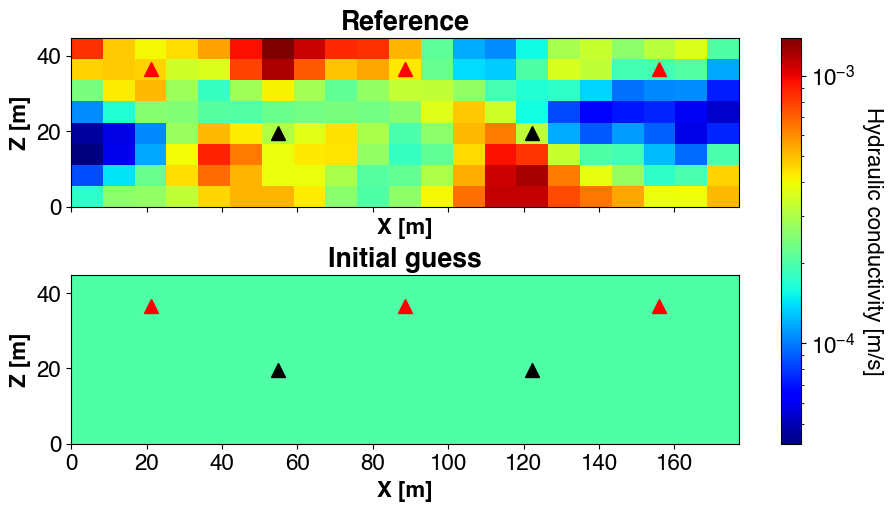

In [12]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax1-2"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference": hc_ref,
        "Initial guess": hc_est,
    },
    cbar_title="Hydraulic conductivity [m/s]",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "norm": LogNorm(),
        "aspect": "equal",
    },
    xlabel="X [m]",
    ylabel="Z [m]",
)

# plotter.subfigs["fig0"].suptitle("Permeability field [m/s]", fontweight="bold")

for ax in plotter.ax_dict.values():
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="prod wells",
            marker="^",
            markersize=10,
            c="black",
            linestyle="none",
        )

    for well_pos in injection_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="inj wells",
            marker="^",
            markersize=10,
            c="red",
            linestyle="none",
        )

fname = "ref_vs_ig_hc_field"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Create the flowrates for the wells: 12 m3/h decreasing following an exponential... for the producers with a balanced injection (2 m3/h per associated cell for the injectors).

In [13]:
def gen_flowrates(amplitude: float, coef: float, nt: int, dt: float) -> NDArrayFloat:
    """Generate flowrates with a given amplitude and decrease coefficient.

    Parameters
    ----------
    amplitude : float
        Amplitude in m3/h.
    coef : float
        Decrease coefficient.
    nt : int
        Number of timesteps
    dt : float
        Timesteps.

    Returns
    -------
    np.ndarray
        The flowrates.
    """
    return amplitude * np.exp(coef * np.arange(nt) * dt)

- Generate a flowrates with an initial amplitude at 1 m3/h and plot it

Text(0.5, 0, 'time [d]')

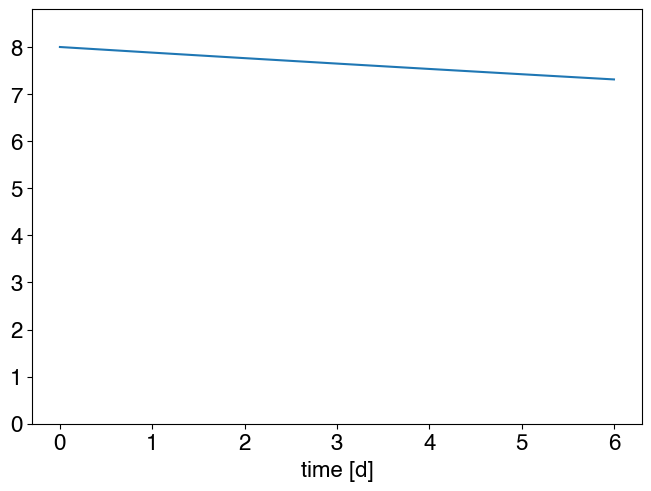

In [14]:
init_prod_flowrates = 8.0  # m3/s
# nt+1 because we consider the initial state too
flowrates = init_prod_flowrates * gen_flowrates(
    1.0, -0.015, duration_in_days, dt=1
)  # m3/s

plt.plot(np.arange(duration_in_days), flowrates)
plt.ylim(0.0, init_prod_flowrates * 1.1)
plt.xlabel("time [d]")

### Forward problem definition in PyRTID

In [15]:
def gen_fwd_model(geom: dmfwd.Geometry) -> dmfwd.ForwardModel:
    time_params = dmfwd.TimeParameters(
        duration=duration_in_s, dt_init=dt_init, dt_max=dt_max, dt_min=dt_min
    )
    fl_params = dmfwd.FlowParameters(
        permeability=k0,
        storage_coefficient=storage_coefficient,
        regime={
            "stationary": dmfwd.FlowRegime.STATIONARY,
            "transient": dmfwd.FlowRegime.TRANSIENT,
        }[flow_regime],
        crank_nicolson=crank_flow,
        vertical_axis=dmfwd.VerticalAxis.DY,  # the y axis is the vertical
    )
    tr_params = dmfwd.TransportParameters(
        diffusion=D0,
        porosity=w0,
        crank_nicolson_diffusion=crank_diff,
        crank_nicolson_advection=crank_adv,
    )
    gch_params = dmfwd.GeochemicalParameters(conc=c0)

    return dmfwd.ForwardModel(geom, time_params, fl_params, tr_params, gch_params)


geom_x1 = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dy, dz=dz)
base_model_x1 = gen_fwd_model(geom_x1)

- Add boundary conditions

In [16]:
def add_boundary_conditions(model: dmfwd.ForwardModel, geom: dmfwd.Geometry) -> None:
    model.fl_model.set_initial_head(initial_head_in_m)

    # Boundary conditions
    model.add_boundary_conditions(dmfwd.ConstantHead(span=(slice(0, 1), slice(None))))
    model.fl_model.set_initial_head(cst_head_left, span=(slice(0, 1), slice(None)))
    model.add_boundary_conditions(
        dmfwd.ConstantHead(span=(slice(geom.nx - 1, geom.nx), slice(None)))
    )
    model.fl_model.set_initial_head(
        cst_head_right, span=(slice(geom.nx - 1, geom.nx), slice(None))
    )


add_boundary_conditions(base_model_x1, geom_x1)

- Add source and sink terms

In [17]:
def add_src_sink_terms(
    model: dmfwd.ForwardModel, geom: dmfwd.Geometry, scaling: int = 1
) -> None:
    prod_flw = -flowrates / 3600  # m3/h to m3/s
    fw_times_in_s = (
        np.arange(stop=duration_in_days, start=0, dtype=np.float_) * 3600 * 24
    )  # in seconds

    # two successive pumping on days 1 and 2
    for loc in production_locations:
        sink_term = dmfwd.SourceTerm(
            f"producer loc # {loc}",
            node_ids=np.array(
                indices_to_node_number(
                    loc[0] * scaling, nx=geom.nx, iy=loc[1] * scaling
                )
            ),
            # pumping on 1 day
            times=fw_times_in_s,
            flowrates=prod_flw,
            concentrations=np.zeros((*fw_times_in_s.shape, 2)),
        )
        model.add_src_term(sink_term)

    n_prod_linked_list = [1, 2, 1]

    # three successive injections on days 3, 4 and 5
    for count_inj, loc in enumerate(injection_locations):
        source_term = dmfwd.SourceTerm(
            "injector loc # {loc}",
            node_ids=np.array(
                indices_to_node_number(
                    loc[0] * scaling, nx=geom.nx, iy=loc[1] * scaling
                )
            ),
            times=fw_times_in_s,
            flowrates=-n_prod_linked_list[count_inj] * prod_flw / 2,
            concentrations=np.ones((*fw_times_in_s.shape, 2))
            * c_inj,  # injection concentration
        )
        model.add_src_term(source_term)


add_src_sink_terms(base_model_x1, geom_x1, scaling=1)

- Create two models

In [18]:
model_reference = copy.deepcopy(base_model_x1)
model_estimate = copy.deepcopy(base_model_x1)
# Reference
model_reference.fl_model.permeability = hc_ref.reshape(nx, ny)
# Estimated diffusion
model_estimate.fl_model.permeability = hc_est.reshape(nx, ny)
model_reference.tr_model.set_initial_conc(c0)
model_estimate.tr_model.set_initial_conc(c0)

- Run the models

In [19]:
solver_reference = dmfwd.ForwardSolver(model_reference)
solver_reference.solve()

In [20]:
solver_estimate = dmfwd.ForwardSolver(model_estimate)
solver_estimate.solve()

### Forward problem results

### Head, pressure, and darcy velocities

- spatial evolution of heads

In [22]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax1-2"]],
            sharey=True,
            sharex=True,
        )
    },
)

nb_frames = min(model_estimate.time_params.nt, 15)

plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2"],
    fig=plotter.fig,
    data={
        # Warning: observation 0 matches sample 1
        "Reference (PyRTID)": model_reference.fl_model.head[:, :, :],
        "Initial guess (PyRTID)": model_estimate.fl_model.head[:, :, :],
    },
    cbar_title="Head [m]",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
    nb_frames=nb_frames,
)

plotter.subfigs["fig0"].suptitle("Head field [m]", fontweight="bold")
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath(
    "head_field_reference_vs_initial_guess_animated.html"
)
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


KeyboardInterrupt: 

- Pressure evolution

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax1-2"]],
            sharey=True,
            sharex=True,
        )
    },
)

nb_frames = min(model_estimate.time_params.nt, 15)

plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2"],
    fig=plotter.fig,
    data={
        # Warning: observation 0 matches sample 1
        "Reference (PyRTID)": model_reference.fl_model.get_pressure_bar()[:, :, :],
        "Initial guess (PyRTID)": model_estimate.fl_model.get_pressure_bar()[:, :, :],
    },
    cbar_title="Pressure [bar]",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
    nb_frames=nb_frames,
)

plotter.subfigs["fig0"].suptitle("Pressure [bar]", fontweight="bold")
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath(
    "pressure_field_reference_vs_initial_guess_animated.html"
)
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


- Concentration evolution

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax1-2"]],
            sharey=True,
            sharex=True,
        )
    },
)

nb_frames = min(model_estimate.time_params.nt, 15)


plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2"],
    fig=plotter.fig,
    data={
        # Warning: observation 0 matches sample 1
        "Reference (PyRTID)": model_reference.tr_model.conc[:, :, :],
        "Initial guess (PyRTID)": model_estimate.tr_model.conc[:, :, :],
    },
    cbar_title="Tracer concentration [molal]",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Z [m]",
    nb_frames=nb_frames,
)

for ax in plotter.ax_dict.values():
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="prod wells",
            marker="^",
            markersize=10,
            c="violet",
            linestyle="none",
        )

    for well_pos in injection_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="inj wells",
            marker="^",
            markersize=10,
            c="g",
            linestyle="none",
        )

plotter.subfigs["fig0"].suptitle("Tracer concentration [molal]", fontweight="bold")
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath(
    "concentration_reference_vs_initial_guess_animated.html"
)
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


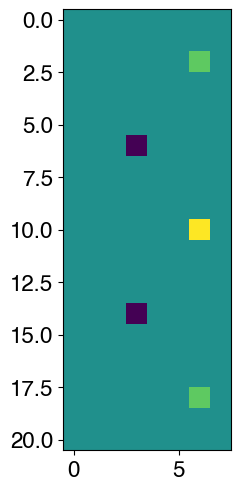

In [ ]:
plt.imshow(model_estimate.fl_model.unitflow[:, :, 3])

- Density evolution

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax1-2"]], sharey=True, sharex=True)
    },
)

nb_frames = min(model_estimate.time_params.nt, 15)

plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2"],
    fig=plotter.fig,
    data={
        # Warning: observation 0 matches sample 1
        "Reference": model_reference.tr_model.density[:, :, :],
        "Initial guess": model_estimate.tr_model.density[:, :, :],
    },
    cbar_title="Tracer concentration [molal]",
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Z [m]",
    nb_frames=nb_frames,
)

for ax in plotter.ax_dict.values():
    # Add some vertical lines to indicate the well
    for well_pos in production_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="prod wells",
            marker="^",
            markersize=10,
            c="violet",
            linestyle="none",
        )

    for well_pos in injection_locations:
        ax.plot(
            well_pos[0] * dx + dx / 2,
            well_pos[1] * dy + dy / 2,
            label="inj wells",
            marker="^",
            markersize=10,
            c="g",
            linestyle="none",
        )

plotter.subfigs["fig0"].suptitle("Density [kg/m3]", fontweight="bold")
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("density_reference_vs_initial_guess_animated.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


### Head and pressure at wells

We sample heads in the first half of the simulation, and pressure in the second half of the simulation so we can test the implementation with both. We also add a small overlap (2 observations).


In [ ]:
freq_measure_in_d = 1.0  # one measure every two days
n_sampled_days = duration_in_days / freq_measure_in_d

obs_times_in_s = np.arange(n_sampled_days) * 3600 * 24 * freq_measure_in_d
obs_times_in_s_head = obs_times_in_s[:]
logging.info(f"obs_times_in_s_head = {obs_times_in_s_head}")

INFO:root:obs_times_in_s_head = [     0.  86400. 172800. 259200. 345600. 432000. 518400.]


In [ ]:
noise_std_head: float = 0.5  # This is an absolute value in m


def get_white_noise(shape: Iterable[int], noise_std: float) -> NDArrayFloat:
    """
    Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return np.random.default_rng(2021).normal(
        mean_noise, noise_std, size=np.array(shape)
    )


# Generate a white noise
obs_noise_head: NDArrayFloat = get_white_noise(
    (len(production_locations), obs_times_in_s_head.size), noise_std_head
)

In [ ]:
production_locations

[(6, 3, 0), (14, 3, 0)]

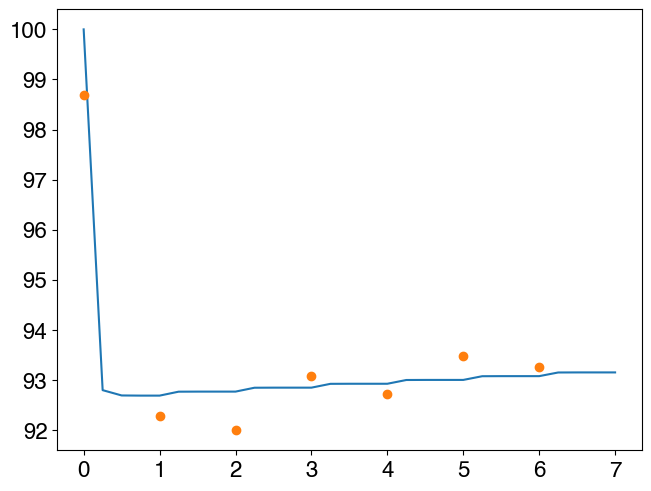

In [ ]:
all_times = model_estimate.time_params.times

obs_values_head = np.zeros((len(production_locations), obs_times_in_s_head.size))

for count, (ix, iy, iz) in enumerate(production_locations):
    # interpolate the values
    obs_values_head[count] = (
        sp.interpolate.interp1d(
            all_times, model_reference.fl_model.head[ix, iy, :], kind="cubic"
        )(obs_times_in_s_head)
        + obs_noise_head[count, :]
    )

count = 1

ix, iy, iz = production_locations[count]
plt.plot(all_times / 3600 / 24, model_reference.fl_model.head[ix, iy, :])
plt.plot(
    obs_times_in_s_head / 3600 / 24,
    obs_values_head[count],
    marker="o",
    linestyle="none",
)

- Forward variables at the producer locations

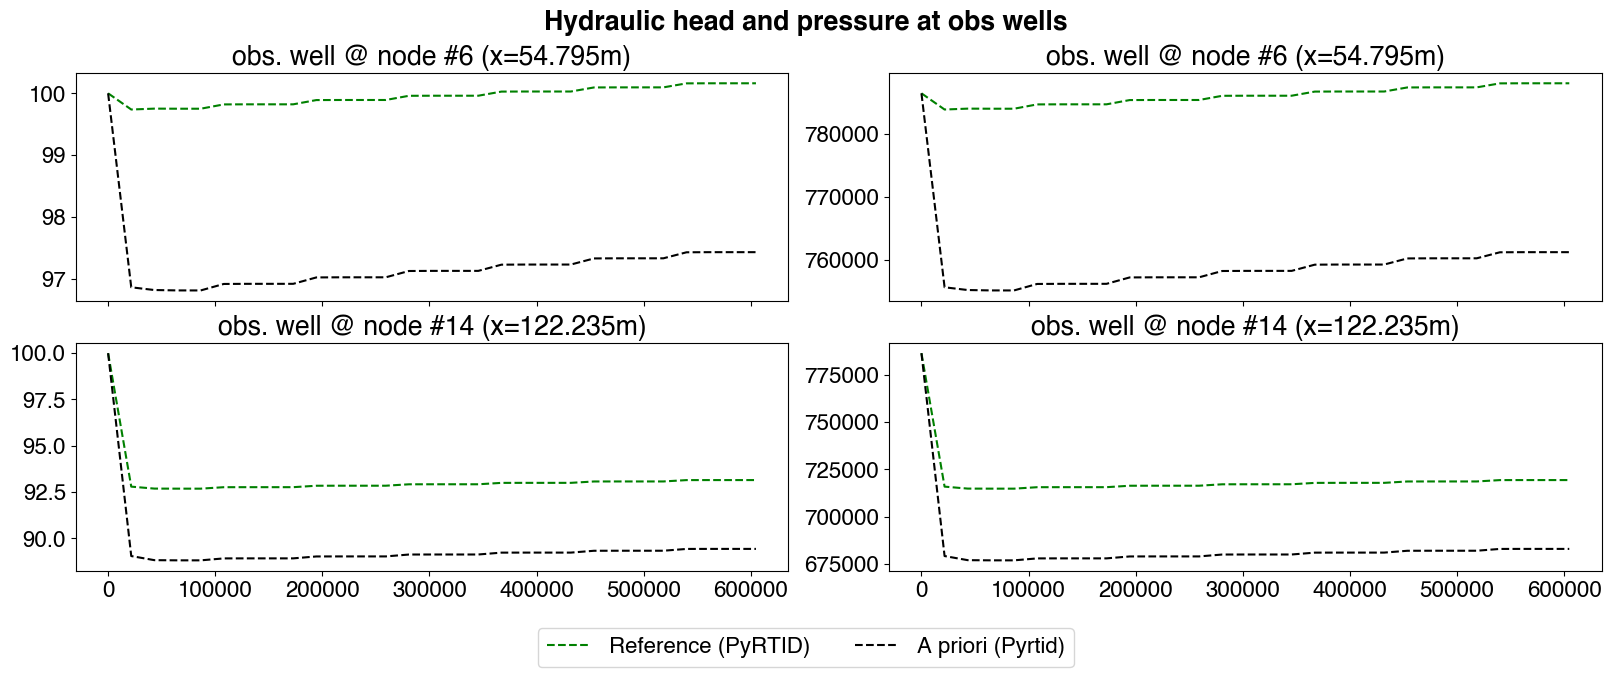

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (16, 6)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2"], ["ax2-1", "ax2-2"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, (ix, iy, iz) in enumerate(production_locations):
    x = (ix + 0.5) * dx
    y = (iy + 0.5) * dy
    z = (iz + 0.5) * dz

    # Head
    ax = plotter.get_axis(f"ax{i + 1}-1")
    obs_well_name = f"obs. well @ node #{ix} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        model_reference.time_params.times,
        model_reference.fl_model.head[ix, iy, :],
        label="Reference (PyRTID)",
        c="g",
        linestyle="--",
    )
    ax.plot(
        model_estimate.time_params.times,
        model_estimate.fl_model.head[ix, iy, :],
        label="A priori (Pyrtid)",
        c="k",
        linestyle="--",
    )

    # Pressure
    ax = plotter.get_axis(f"ax{i + 1}-2")
    obs_well_name = f"obs. well @ node #{ix} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        model_reference.time_params.times,
        model_reference.fl_model.pressure[ix, iy, :],
        label="Reference (PyRTID)",
        c="g",
        linestyle="--",
    )
    ax.plot(
        model_estimate.time_params.times,
        model_estimate.fl_model.pressure[ix, iy, :],
        label="A priori (Pyrtid)",
        c="k",
        linestyle="--",
    )

    # ax.plot(
    #     ,
    #     model_reference.fl_model.head[ix, iy, :],
    #     label="Reference (PyRTID)",
    #     c="b",
    #     linestyle="--",
    # )
    # ax.plot(
    #     grid_sample_times,
    #     model_estimate.fl_model.head[ix, iy, :],
    #     label="A priori (PyRTID)",
    #     c="r",
    #     linestyle="--",
    # )

plotter.fig.suptitle("Hydraulic head and pressure at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "head_and_pressure_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Concentration at producers

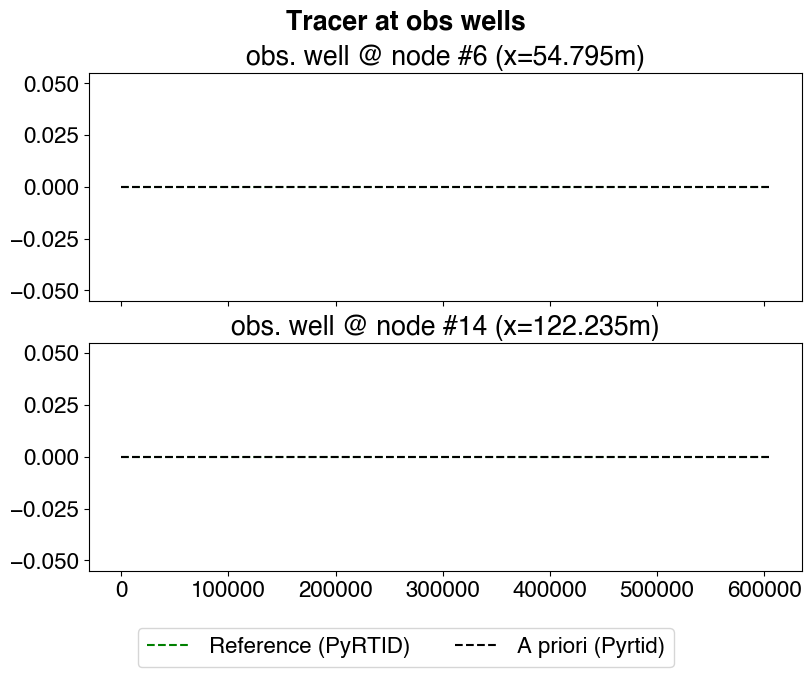

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 6)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, (ix, iy, iz) in enumerate(production_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (ix + 0.5) * dx
    y = (iy + 0.5) * dy
    z = (iz + 0.5) * dz
    obs_well_name = f"obs. well @ node #{ix} (x={x}m)"

    ax.set_title(obs_well_name)

    ax.plot(
        model_reference.time_params.times,
        model_reference.tr_model.conc[ix, iy, :],
        label="Reference (PyRTID)",
        c="g",
        linestyle="--",
    )
    ax.plot(
        model_estimate.time_params.times,
        model_estimate.tr_model.conc[ix, iy, :],
        label="A priori (Pyrtid)",
        c="k",
        linestyle="--",
    )


plotter.fig.suptitle("Tracer at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "tracer_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

## Gradient with respect to the permeability

In [ ]:
param_x1 = dminv.AdjustableParameter(
    name=dminv.ParameterName.PERMEABILITY,
    # /10 to avoid finite differences fail because of bounds clipping
    lbounds=min_val / 10,
    # * 10 to avoid finite differences fail because of bounds clipping
    ubounds=max_val * 10,
    preconditioner=dminv.LogTransform(),
)

observables_x1 = []
for i, (ix, iy, iz) in enumerate(production_locations):
    node_id = indices_to_node_number(ix, nx=nx, iy=iy, ny=ny)
    observables_x1.append(
        pyrtid.inverse.Observable(
            state_variable=pyrtid.inverse.StateVariable.HEAD,
            node_indices=node_id,
            times=obs_times_in_s_head,
            values=obs_values_head[i],
            uncertainties=noise_std_head,
        )
    )

# Create an executor to keep track of the adjoint model
solver_config = dminv.ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 20, "maxiter": 20, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=False,
    is_adj_numerical_acceleration=True,
    afpi_eps=1e-15,
)
model_adjusted_x1 = copy.deepcopy(model_estimate)
inverse_model_x1 = dminv.InverseModel(param_x1, observables_x1)
executor_x1 = dminv.ScipyInversionExecutor(
    model_adjusted_x1, inverse_model_x1, solver_config
)

executor_x1.eval_scaled_loss(param_x1.preconditioner(param_x1.values))

is_grad_ok = executor_x1.is_adjoint_gradient_correct(
    max_workers=max_workers,
    is_verbose=False,
)

INFO:root:- Running forward model # 1


INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 18.93018023261601
INFO:root:Loss (regularization) = 0.0
INFO:root:Regularization weight = 0.0
INFO:root:Scaling factor        = 0.05282569884237216
INFO:root:Loss (scaled)         = 1.0



In [ ]:
logging.info(f"Is the gradient correct: {is_grad_ok}")

INFO:root:Is the gradient correct: True


In [ ]:
x0 = param_x1.preconditioner(param_x1.values)
eps = np.power(np.finfo(float).eps, 1 / 3) * min(1, np.max(np.abs(x0)))
eps

6.055454452393343e-06

In [ ]:
np.savetxt(
    "gradient_x1_adj.txt",
    param_x1.grad_adj_history[0] * executor_x1.inv_model.scaling_factor,
)
np.savetxt(
    "gradient_x1_fd.txt",
    param_x1.grad_fd_history[0] * executor_x1.inv_model.scaling_factor,
)

- Plot the gradients

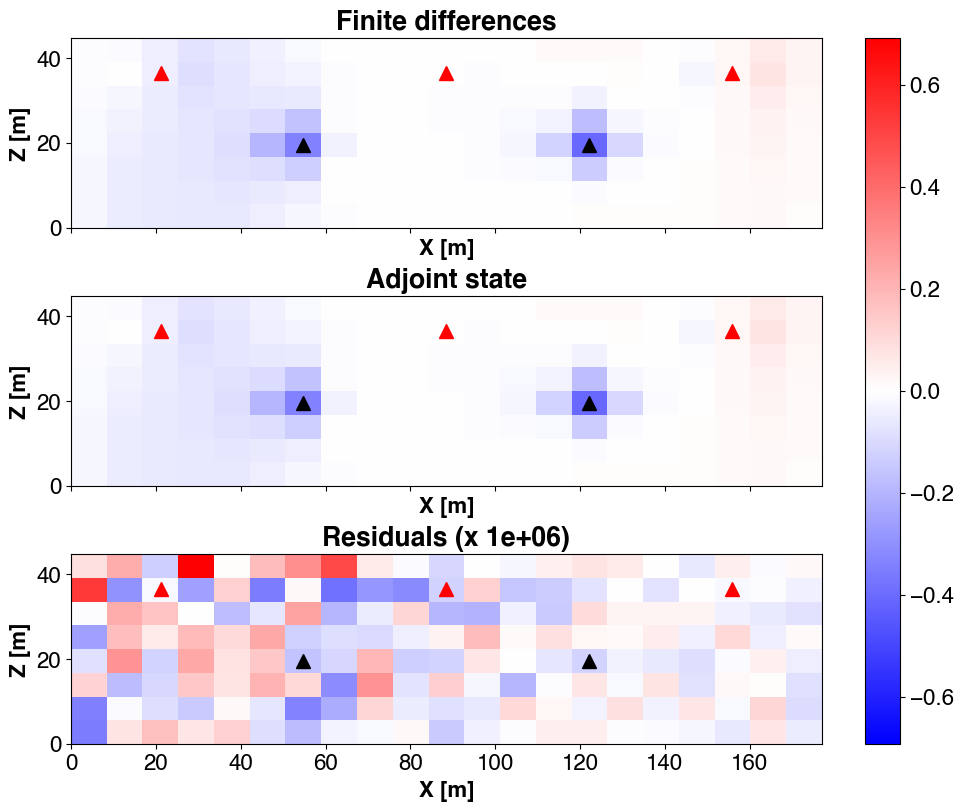

In [ ]:
def plot_gradient_res(
    param: dminv.AdjustableParameter,
    geom: dmfwd.Geometry,
    scaling_factor: float,
    fname: str,
    grid_scaling: float = 1.0,
    res_scaling: Optional[float] = None,
) -> None:
    plotter = ngp.NestedGridPlotter(
        fig_params={"constrained_layout": True, "figsize": (10, 8)},
        subplots_mosaic_params={
            "fig0": dict(
                mosaic=[["ax1-1"], ["ax1-2"], ["ax1-3"]],
                sharey=True,
                sharex=True,
            )
        },
    )

    # We multiply the residuals so that the hight residulas is just below the max values
    adj_grad = param.grad_fd_history[0] * scaling_factor
    fd_grad = param.grad_adj_history[0] * scaling_factor
    residuals = adj_grad - fd_grad

    if res_scaling is None:
        res_factor = 1.0
        while np.max(np.abs(adj_grad)) > np.max(np.abs(residuals)) * res_factor:
            res_factor *= 2.0
        # Make sure it is below
        res_factor /= 2.0
    else:
        res_factor = res_scaling

    ngp.multi_imshow(
        axes=plotter.axes,
        fig=plotter.fig,
        data={
            "Finite differences": adj_grad,
            "Adjoint state": fd_grad,
            f"Residuals (x {res_factor:.0e})": residuals * res_factor,
        },
        imshow_kwargs={
            "extent": [0.0, geom.nx * geom.dx, 0.0, geom.ny * geom.dy],
            "aspect": "equal",
        },
        xlabel="X [m]",
        ylabel="Z [m]",
        is_symmetric_cbar=True,
    )

    # plotter.subfigs["fig0"].suptitle(
    #     "J Gradient with respect to permeability", fontweight="bold"
    # )

    for ax in plotter.ax_dict.values():
        # Add some vertical lines to indicate the well
        for well_pos in production_locations:
            ax.plot(
                well_pos[0] * grid_scaling * geom.dx + geom.dx / 2,
                well_pos[1] * grid_scaling * geom.dy + geom.dy / 2,
                label="prod wells",
                marker="^",
                markersize=10,
                c="black",
                linestyle="none",
            )

        for well_pos in injection_locations:
            ax.plot(
                well_pos[0] * grid_scaling * geom.dx + geom.dx / 2,
                well_pos[1] * grid_scaling * geom.dy + geom.dy / 2,
                label="inj wells",
                marker="^",
                markersize=10,
                c="red",
                linestyle="none",
            )

    for format in ["png", "pdf"]:
        plotter.fig.savefig(
            str(fig_save_path.joinpath(f"{fname}.{format}")), format=format
        )


plot_gradient_res(
    param_x1,
    geom_x1,
    executor_x1.inv_model.scaling_factor,
    "dj_dhc_2d_x1",
    grid_scaling=1,
    res_scaling=1e6,
)

In [ ]:
residuals_x1 = (
    (param_x1.grad_fd_history[0] - param_x1.grad_adj_history[0])
    * executor_x1.inv_model.scaling_factor
    * 1e6
)

In [ ]:
np.mean(residuals_x1)

-0.005603196047832114

In [ ]:
np.std(residuals_x1)

0.15427364085180367

In [ ]:
def make_symmetric_bins(bins: NDArrayFloat) -> NDArrayFloat:
    step = np.diff(bins)[0]
    if np.abs(bins[-1]) > np.abs(bins[0]):
        nbins = int(bins[bins > 0].size * 2)
        return np.ones(nbins) * bins[-1] - np.arange(nbins - 1, -1, step=-1) * step
    else:
        nbins = int(bins[bins < 0].size * 2)
        return np.ones(nbins) * bins[0] + np.arange(0, nbins) * step


def plot_histogram(ax: Axes, values: NDArrayFloat, scaling_factor=1e6) -> None:
    """
    Plot residuals histogram.

    Parameters
    ----------
    ax : Axes
        Axis on which to plot the histogram.
    values : NDArrayFloat
        Values of the residuals (shape does not matter).
    scaling_factor : _type_, optional
        Factor to apply so that the residuals are of the same magnitude as the
        gradient values, by default 1e5
    """
    _values = values.ravel()
    # plot the histogram
    n, bins, patches = ax.hist(
        x=_values, bins=20, color="#0504aa", alpha=0.7, density=True
    )

    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    # ax.set_ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

    sigma = np.std(_values)
    mu = np.mean(_values)

    # Set the average line ---(red)
    ax.axvline(values.mean(), color="r", linestyle="dashed", linewidth=1)
    # Display the average and the standard deviation on the graph
    min_xlim, max_xlim = ax.get_xlim()
    min_ylim, max_ylim = ax.get_ylim()
    # calculate the text (x, y) position
    x_pos = values.mean() + 0.15 * (max_xlim - min_xlim)
    y_pos = max_ylim * 0.8
    ax.text(
        x_pos,
        y_pos,
        r"$\mu$: {:.2e}".format(values.mean())
        + "\n"
        + r"$\sigma$: {:.2e}".format(values.std()),
    )

    # Ensure a symmetric x axis
    make_x_axes_symmetric_zero_centered([ax])

    # add a 'best fit' line
    min_xlim, max_xlim = ax.get_xlim()
    # _bins = make_symmetric_bins(bins)
    x = np.linspace(min_xlim, max_xlim, 30)
    y = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (x - mu)) ** 2)
    ax.plot(x, y, "--", c="k")

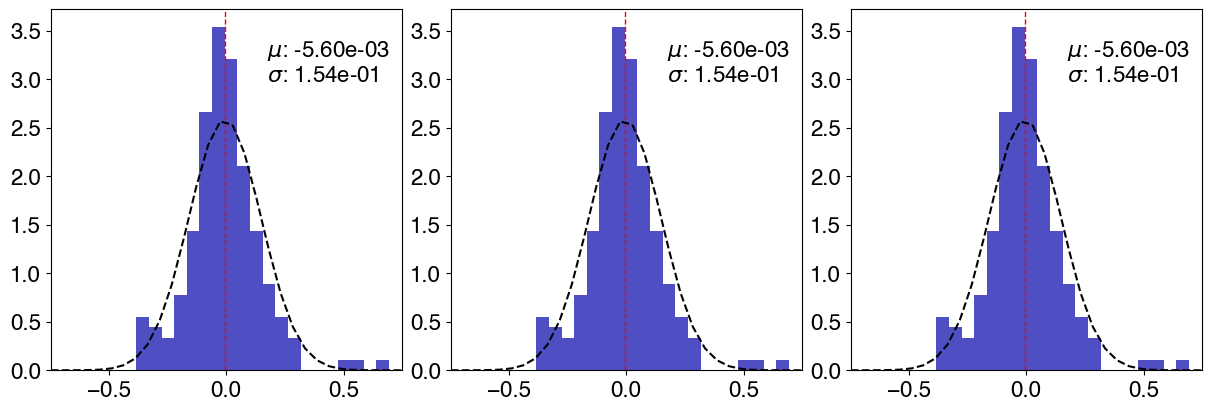

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 4)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2", "ax1-3"]],
            sharey=False,
            sharex=False,
        )
    },
)

plot_histogram(plotter.get_axis("ax1-1"), residuals_x1, scaling_factor=1e6)
plot_histogram(plotter.get_axis("ax1-2"), residuals_x1, scaling_factor=1e6)
plot_histogram(plotter.get_axis("ax1-3"), residuals_x1, scaling_factor=1e6)

## Domain downscaling

In this part, we update the domain and multiply it by 2 on each axis and then by 4.

In [43]:
geom_x4 = copy.deepcopy(geom_x1)
geom_x4.nx *= 2
geom_x4.ny *= 2
geom_x4.dx /= 2
geom_x4.dy /= 2

geom_x16 = copy.deepcopy(geom_x1)
geom_x16.nx *= 4
geom_x16.ny *= 4
geom_x16.dx /= 4
geom_x16.dy /= 4

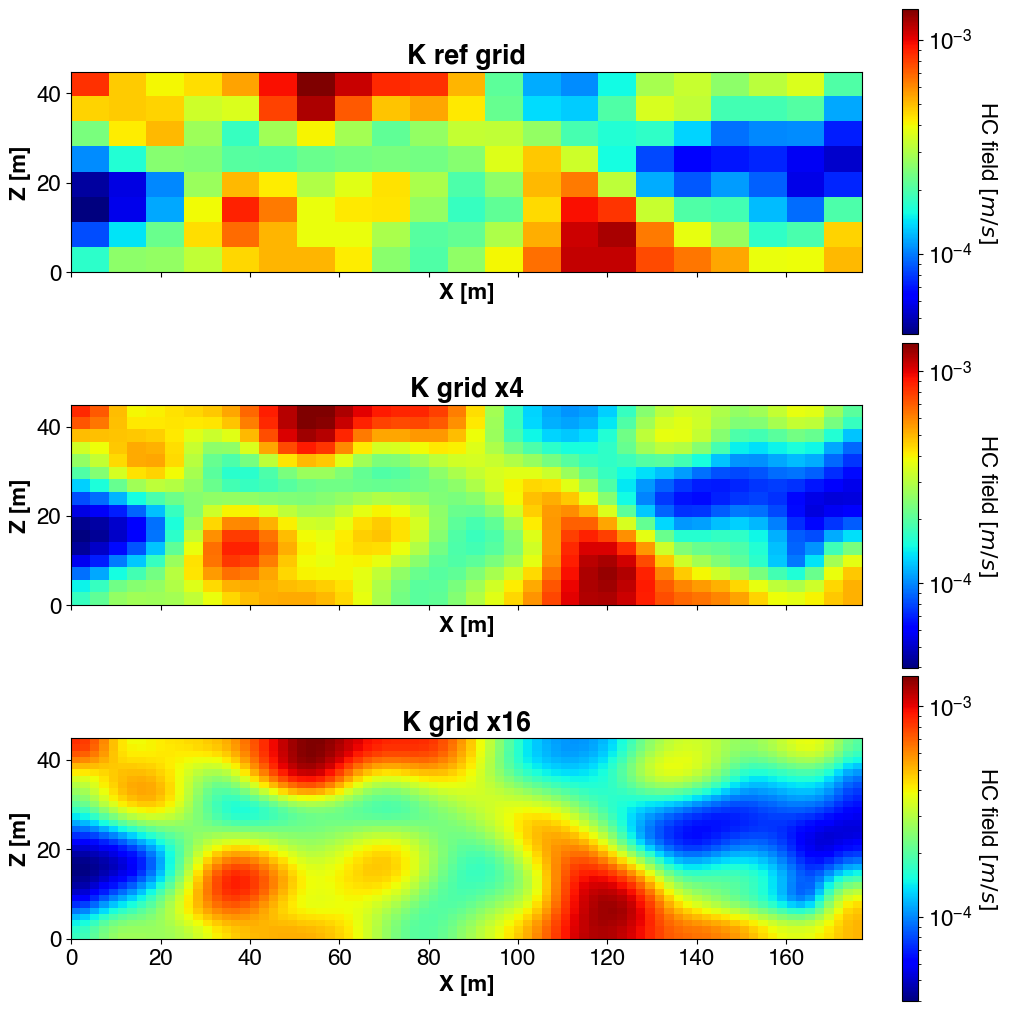

In [44]:
def resample_perm(geom: dmfwd.Geometry, perm: NDArrayFloat) -> NDArrayFloat:
    # resample from 100 x 75 to nx * ny
    _XX, _YY = np.meshgrid(
        np.linspace(0.0, geom_x1.nx - 1, geom.nx),
        np.linspace(0, geom_x1.ny - 1, geom.ny),
    )
    _pts = np.hstack((_XX.ravel()[:, np.newaxis], _YY.ravel()[:, np.newaxis]))
    return (
        sp.ndimage.map_coordinates(perm, coordinates=_pts.T).reshape(geom.ny, geom.nx).T
    )


hc_x4 = resample_perm(geom_x4, hc_ref)
hc_x16 = resample_perm(geom_x16, hc_ref)


plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 10)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax1-2"], ["ax1-3"]],
            sharey=False,
            sharex=True,
        )
    },
)

# Plot the permeability
for ax, label, perm, geom in zip(
    plotter.axes,
    ["K ref grid", "K grid x4", "K grid x16"],
    [hc_ref, hc_x4, hc_x16],
    [geom_x1, geom_x4, geom_x16],
):
    ngp.multi_imshow(
        axes=[ax],
        fig=plotter.fig,
        data={label: perm},
        cbar_title="HC field $[m/s]$",
        imshow_kwargs={
            "cmap": plt.get_cmap("jet"),
            "norm": LogNorm(),
            "extent": [0.0, geom.nx * geom.dx, 0.0, geom.ny * geom.dy],
            "aspect": "equal",
        },
        xlabel="X [m]",
        ylabel="Z [m]",
    )

fname = "K_upscaling"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [45]:
scaling = 2
param_x4 = dminv.AdjustableParameter(
    name=dminv.ParameterName.PERMEABILITY,
    # /10 to avoid finite differences fail because of bounds clipping
    lbounds=min_val / 10,
    # * 10 to avoid finite differences fail because of bounds clipping
    ubounds=max_val * 10,
    preconditioner=dminv.LogTransform(),
)

observables_x4 = []
for i, (ix, iy, iz) in enumerate(production_locations):
    node_id = indices_to_node_number(
        ix * scaling, nx=geom_x4.nx, iy=iy * scaling, ny=geom_x4.ny
    )
    observables_x4.append(
        pyrtid.inverse.Observable(
            state_variable=pyrtid.inverse.StateVariable.HEAD,
            node_indices=node_id,
            times=obs_times_in_s_head,
            values=obs_values_head[i],
            uncertainties=noise_std_head,
        )
    )

# we do not modify the solver config
# but we need to create a new downscaled model
model_adjusted_x4 = gen_fwd_model(geom_x4)
add_boundary_conditions(model_adjusted_x4, geom_x4)
add_src_sink_terms(model_adjusted_x4, geom_x4, scaling=2)
model_adjusted_x4.fl_model.permeability = resample_perm(geom_x4, hc_est)  # m2/s

dmfwd.ForwardSolver(model_adjusted_x4).solve()

inverse_model_x4 = dminv.InverseModel(param_x4, observables_x4)
executor_x4 = dminv.ScipyInversionExecutor(
    model_adjusted_x4, inverse_model_x4, solver_config
)

executor_x4.eval_scaled_loss(param_x4.preconditioner(param_x4.values))

# grad = executor_x4.eval_scaled_loss_gradient(param_x4.preconditioner(param_x4.values))
is_grad_ok_x4 = executor_x4.is_adjoint_gradient_correct(
    max_workers=max_workers, is_verbose=False
)

INFO:root:- Running forward model # 1
INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 31.427863715743673
INFO:root:Loss (regularization) = 0.0
INFO:root:Regularization weight = 0.0
INFO:root:Scaling factor        = 0.031818898320443385
INFO:root:Loss (scaled)         = 1.0



KeyboardInterrupt: 

In [ ]:
np.savetxt(
    "gradient_x4_adj.txt",
    param_x4.grad_adj_history[0] * executor_x4.inv_model.scaling_factor,
)
np.savetxt(
    "gradient_x4_fd.txt",
    param_x4.grad_fd_history[0] * executor_x4.inv_model.scaling_factor,
)

In [ ]:
geom_x4.nx

42

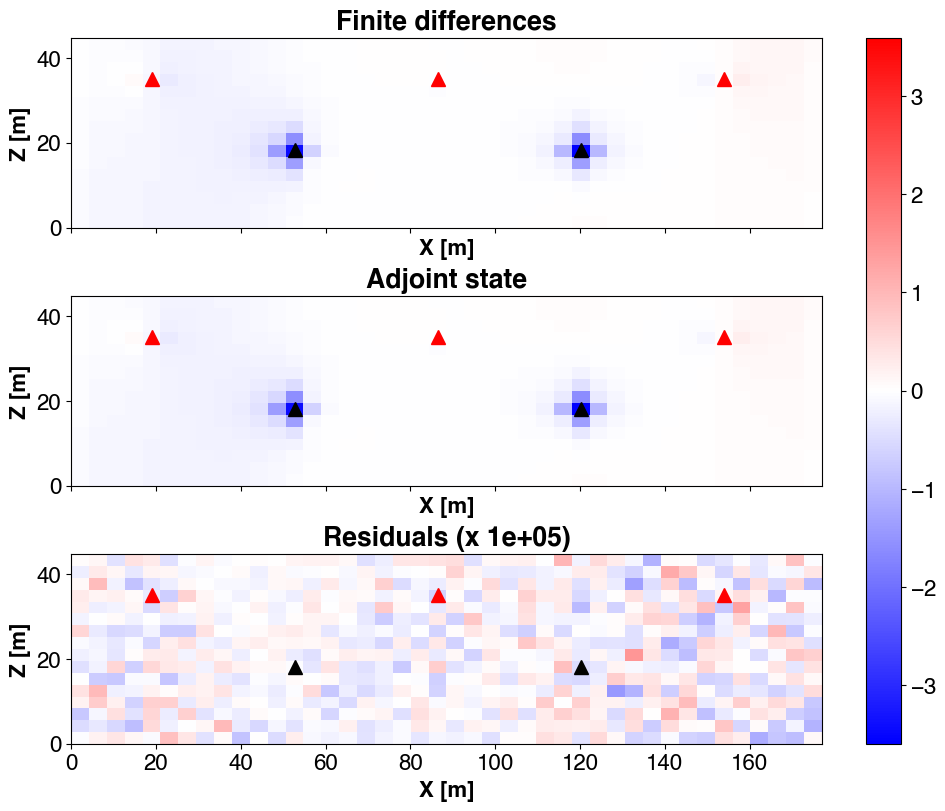

In [ ]:
plot_gradient_res(
    param_x4, geom_x4, 1.0, "dj_dhc_2d_x4", grid_scaling=2, res_scaling=1e5
)

In [ ]:
scaling = 4
param_x16 = dminv.AdjustableParameter(
    name=dminv.ParameterName.PERMEABILITY,
    # /10 to avoid finite differences fail because of bounds clipping
    lbounds=min_val / 10,
    # * 10 to avoid finite differences fail because of bounds clipping
    ubounds=max_val * 10,
    preconditioner=dminv.LogTransform(),
)

observables_x16 = []
for i, (ix, iy, iz) in enumerate(production_locations):
    node_id = indices_to_node_number(
        ix * scaling, nx=geom_x16.nx, iy=iy * scaling, ny=geom_x16.ny
    )
    observables_x16.append(
        pyrtid.inverse.Observable(
            state_variable=pyrtid.inverse.StateVariable.HEAD,
            node_indices=node_id,
            times=obs_times_in_s_head,
            values=obs_values_head[i],
            uncertainties=noise_std_head,
        )
    )

# we do not modify the solver config
# but we need to create a new downscaled model
model_adjusted_x16 = gen_fwd_model(geom_x16)
add_boundary_conditions(model_adjusted_x16, geom_x16)
add_src_sink_terms(model_adjusted_x16, geom_x16, scaling=4)
model_adjusted_x16.fl_model.permeability = resample_perm(geom_x16, hc_est)  # m2/s

dmfwd.ForwardSolver(model_adjusted_x16).solve()

inverse_model_x16 = dminv.InverseModel(param_x16, observables_x16)
executor_x16 = dminv.ScipyInversionExecutor(
    model_adjusted_x16, inverse_model_x16, solver_config
)

executor_x16.eval_scaled_loss(param_x16.preconditioner(param_x16.values))

grad = executor_x16.eval_scaled_loss_gradient(
    param_x16.preconditioner(param_x16.values)
)
is_grad_ok_x16 = executor_x16.is_adjoint_gradient_correct(
    max_workers=max_workers, is_verbose=False
)

INFO:root:- Running forward model # 1
INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 18.58526429258312
INFO:root:Loss (regularization) = 0.0
INFO:root:Scaling factor        = 0.05380606830536562
INFO:root:Loss (scaled)         = 1.0



1.0

In [ ]:
np.savetxt(
    "gradient_x16_adj.txt",
    param_x16.grad_adj_history[0] * executor_x16.inv_model.scaling_factor,
)
np.savetxt(
    "gradient_x16_fd.txt",
    param_x16.grad_fd_history[0] * executor_x16.inv_model.scaling_factor,
)

IndexError: list index out of range

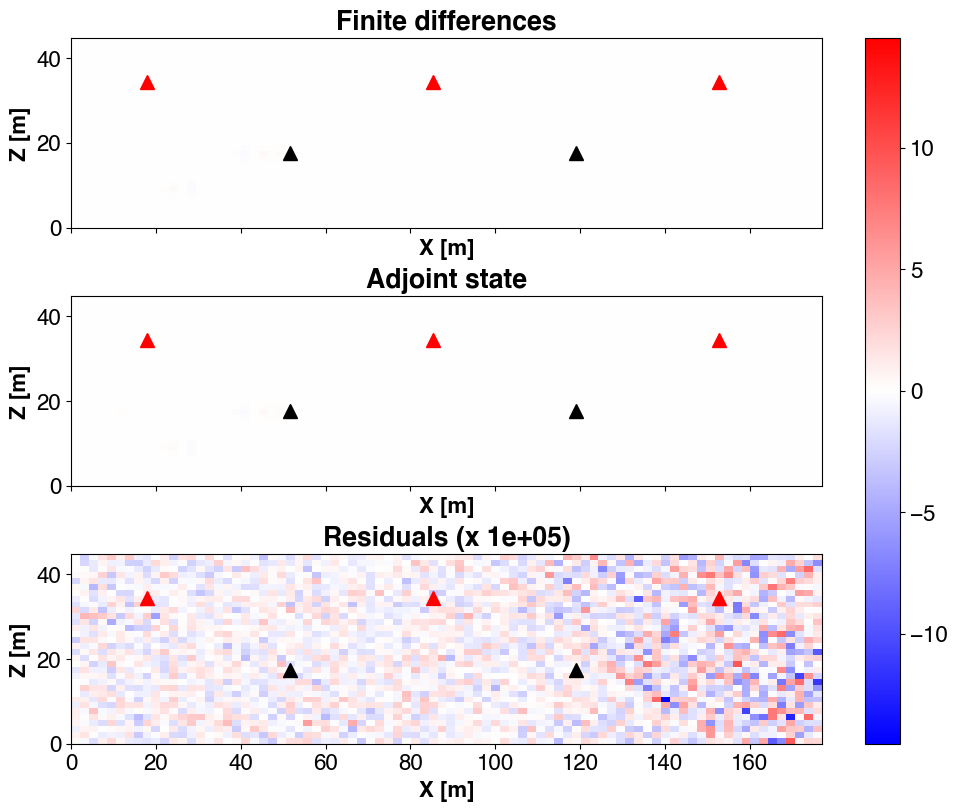

In [ ]:
plot_gradient_res(
    param_x16, geom_x16, 1.0, "dj_dhc_2d_x16", grid_scaling=4, res_scaling=1e5
)

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 3)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2", "ax1-3"]],
            sharey=False,
            sharex=False,
        )
    },
)

residuals_x1 = (
    (param_x1.grad_fd_history[0] - param_x1.grad_adj_history[0])
    * executor_x1.inv_model.scaling_factor
    * 1e5
)
residuals_x4 = (
    (param_x4.grad_fd_history[0] - param_x4.grad_adj_history[0])
    * executor_x4.inv_model.scaling_factor
    * 1e5
)
residuals_x16 = (
    (param_x16.grad_fd_history[0] - param_x16.grad_adj_history[0])
    * executor_x16.inv_model.scaling_factor
    * 1e5
)

plot_histogram(plotter.get_axis("ax1-1"), residuals_x1)
plot_histogram(plotter.get_axis("ax1-2"), residuals_x4)
plot_histogram(plotter.get_axis("ax1-3"), residuals_x16)